# SARSA VS Expected SARSA

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers import StepAPICompatibility
import time

In [2]:
def softmax(x, temp):
  softmax_probs = np.exp(x/temp)
  sum = np.sum(softmax_probs)

  softmax_probs = softmax_probs/sum
  return softmax_probs

In [3]:
class Sarsa:
  def __init__(self, env, alpha, gamma, temp):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.n_states = env.observation_space.n
    self.n_actions = env.action_space.n
    self.Q = np.zeros((self.n_states, self.n_actions))

  def select_action(self, s, greedy=False):
    actions = self.Q[s]
    if greedy:
      # if finished training, then choose the optimal policy
      return np.random.choice(np.flatnonzero(actions == np.max(actions)))
    else:
      return np.random.choice(self.n_actions, p=softmax(actions, self.temp))

  def update(self, s, a, r, s_prime, a_prime, done):
    self.Q[s, a] += self.alpha * (r + self.gamma * (0 if done else self.Q[s_prime, a_prime]) - self.Q[s, a])
    return self.Q[s,a]


class ExpectedSarsa:
  def __init__(self, env, alpha, gamma, temp):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.n_states = env.observation_space.n
    self.n_actions = env.action_space.n
    self.Q = np.zeros((self.n_states, self.n_actions))
    return

  def select_action(self, s, greedy=False):
    actions = self.Q[s]
    if greedy:
      # if finished training, then choose the optimal policy
      return np.random.choice(np.flatnonzero(actions == np.max(actions)))
    else:
      return np.random.choice(self.n_actions, p=softmax(actions, self.temp))

  def update(self, s, a, r, s_prime, a_prime, done):
    expected_val = np.sum(self.Q[s_prime] * softmax(self.Q[s_prime], self.temp))
    self.Q[s,a] += self.alpha * (r + (self.gamma * (0  if done else expected_val)) - self.Q[s,a])
    return self.Q[s,a]

In [5]:
env_name = 'FrozenLake-v1'
env = gym.make(env_name)
env = StepAPICompatibility(env)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(4)
State space: Discrete(16)


In [ ]:
# parameters
trials = 10
segments = 500
episodes = 10
gamma = 1      

In [ ]:
# #function that runs each episode
def run_episode(agent, isTest=False):
    # Initialize S
    start = agent.env.reset()
    s = start[0]
    terminal = False
    total_reward = 0
    steps = 0

    # Choose A from S using policy
    if not isTest:
      a = agent.select_action(s, greedy=False)

    else:
      a = agent.select_action(s, greedy=True)

    while not terminal:
        # Take action A, observe R, S'
        s_prime, r, terminal, _, _ = agent.env.step(a)

        total_reward += r
        steps += 1

        if not isTest:
          a_prime = agent.select_action(s_prime, greedy=False)
          agent.update(s, a, r, s_prime, a_prime, terminal)

        else:
          a_prime = agent.select_action(s_prime, greedy=True)

        # Set the new values for s and a
        s = s_prime
        a = a_prime

        if(isTest and steps > 200):
          break
        if(not isTest and steps > 500):
          break
    return total_reward

In [8]:
# Function that runs a segment (default version is 10 episodes of training followed by 1 episode of testing)
def run_segment(agent, training_episodes = 10):
    train_reward = []
    test_reward = 0
    total_reward = []

    for i in range(0, training_episodes):
        train_episode_reward = run_episode(agent, False)
        train_reward.append(train_episode_reward)
        total_reward.append(train_episode_reward)

    test_episode_reward = run_episode(agent, True)
    test_reward += test_episode_reward
    total_reward.append(test_episode_reward)

    return train_reward, test_reward, total_reward

In [9]:
# Function that runs a trial (default version is 500 segments per trial)
def run_trial(agent, segments = 500, training_episodes = 10):
    train_rewards = []
    test_rewards = []

    for i in range(0, segments):
        results = run_segment(agent, training_episodes)
        train_rewards.append(results[0])
        test_rewards.append(results[1])

    return train_rewards, test_rewards

In [10]:
# Function that runs an experiment consisting of 10 trials by default for a combination of alpha and temperature
def run_experiment(agent, temp, lr, segments = 500, training_episodes = 10):
    training_results = []
    testing_results = []

    # Setting the hyperparameters of the agent to the desired ones
    agent.alpha = lr
    agent.temp = temp

    for i in range(0, trials):
        # Since each trial is independant, reset the Q-values of the agent
        agent.Q = np.zeros((agent.n_states, agent.n_actions))

        # Run the trial
        train_rewards, test_rewards = run_trial(agent, segments=segments, training_episodes=training_episodes)
        training_results.append(train_rewards)
        testing_results.append(test_rewards)

    return training_results, testing_results

In [11]:
# Function for plotting the graph of the average return of the agent as a function of alpha for each temperature parameter
def plot1(results,alphas,temperature):
  for temp in temperature:
      ax_1_x = [ np.mean(np.array(results[(alpha, temp)]['training'])[:, -1, :])  for alpha in alphas ]
      plt.plot((np.array(alphas)), ax_1_x, label=f'temp={temp}',alpha=0.8,marker='o')
  x_label = 'alpha'
  y_label = 'average rewards'
  title = 'average rewards for alpha (lr)'
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend()
  plt.show()

# Function for plotting the graph of the average return of the agent as a function of the temperature for each alpha parameter
def plot2(results,alphas,temperature):
  for alpha in alphas:
      ax_2_x = [ np.mean(np.array(results[(alpha, temp)]['training'])[:, -1, :])  for temp in temperature ]
      plt.plot((np.array(temperature)), ax_2_x, label=f'alpha={alpha}',alpha=0.8,marker='o')

  x_label = 'temperature'
  y_label = 'average rewards'
  title = 'average rewards for temperature (temp)'
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend()
  plt.show()

# Function for plotting the graph of the training reward as a function of the number of episodes
def plot3(results,alphas,temperature):
  for temp in temperature:
      for alpha in alphas:
          training_rewards = np.array(results[(alpha, temp)]['training']) # shape (10,500,10) : (trials,segment,episodes)
          reshaped_training_rewards = training_rewards.reshape(training_rewards.shape[0], training_rewards.shape[1] * training_rewards.shape[2]) # shape (10,5000)
          mean_tr_rw = np.mean(reshaped_training_rewards, axis=0) # shape (5000,)
          plt.plot(mean_tr_rw, label=f'alpha={alpha}, temp={temp}')
  x_label = 'episode'
  y_label = 'training rewards'
  title = 'Training rewards for episode'
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend()
  plt.show()

# Function for plotting the graph of the testing reward as a function of the number of episodes
def plot4(results,alphas,temperature):
  for temp in temperature:
      for alpha in alphas:
          testing_rewards = np.array(results[(alpha, temp)]['testing'])
          reshaped_testing_rewards = testing_rewards.reshape(testing_rewards.shape[0], testing_rewards.shape[1])
          mean_te_rw = np.mean(reshaped_testing_rewards, axis=0)
          plt.plot(mean_te_rw, label=f'alpha={alpha}, temp={temp}')
  x_label = 'episode'
  y_label = 'testing rewards'
  title = 'Testing rewards for episode'
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend()
  plt.show()

# Function for plotting a smoothed version of graph 3
def plot3_smooth(results,alphas,temperature):
  for alpha in alphas:
    for temp in temperature:
        training_rewards = np.array(results[(alpha, temp)]['training'])  # shape (10,500,10)
        reshaped_training_rewards = training_rewards.reshape(training_rewards.shape[0], training_rewards.shape[1] * training_rewards.shape[2])  # shape (10,5000)
        mean_tr_rw = np.mean(reshaped_training_rewards, axis=0)  # shape (5000,)
        smoothed_rewards = np.convolve(mean_tr_rw, np.ones(100) / 100, mode='valid')
        plt.plot(smoothed_rewards, label=f'alpha={alpha}, temp={temp}')
  plt.xlabel('episode')
  plt.ylabel('training rewards')
  plt.title('Smoothed Training Rewards for Episode')
  plt.legend()
  plt.show()

# Function for plotting a smoothed version of graph 4
def plot4_smooth(results,alphas,temperature):
  for alpha in alphas:
    for temp in temperature:
        testing_rewards = np.array(results[(alpha, temp)]['testing'])
        reshaped_testing_rewards = testing_rewards.reshape(testing_rewards.shape[0], -1)
        mean_te_rw = np.mean(reshaped_testing_rewards, axis=0)
        smoothed_rewards = np.convolve(mean_te_rw, np.ones(100) / 100, mode='valid')
        plt.plot(smoothed_rewards, label=f'alpha={alpha}, temp={temp}')
  plt.xlabel('episode')
  plt.ylabel('testing rewards')
  plt.title('Smoothed Testing Rewards for Episode')
  plt.legend()
  plt.show()


In [12]:
# Hyperparameters which will be used for training and testing the SARSA and Expected SARSA agents
alphas = [0.001, 0.01,0.1,0.2,0.3,0.5,0.9]
temperature = [0.005,0.01,0.02,0.05,0.1,1,10]

In [15]:
# Training the SARSA agent on the environment
agent = Sarsa(env, 0.1, gamma, 0.005)
rewards = {}
for alpha in alphas:
    for temp in temperature:
        print(f"Beginning iteration for alpha {alpha} and temp {temp}")
        beg = time.time()
        training_results_1, testing_results_1 = run_experiment(agent, temp, alpha , segments=500, training_episodes=10)
        rewards[(alpha, temp)] = {"training" : training_results_1, "testing" : testing_results_1}
        print(f"End of iteration for alpha {alpha} and temp {temp}")
        final = time.time() - beg
        print(f"Time taken: {final} seconds")

Beginning iteration for alpha 0.001 and temp 0.005


c:\Users\admin\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


End of iteration for alpha 0.001 and temp 0.005
Time taken: 26.56047534942627 seconds
Beginning iteration for alpha 0.001 and temp 0.01
End of iteration for alpha 0.001 and temp 0.01
Time taken: 27.761386394500732 seconds
Beginning iteration for alpha 0.001 and temp 0.02
End of iteration for alpha 0.001 and temp 0.02
Time taken: 27.532655715942383 seconds
Beginning iteration for alpha 0.001 and temp 0.05
End of iteration for alpha 0.001 and temp 0.05
Time taken: 30.389118671417236 seconds
Beginning iteration for alpha 0.001 and temp 0.1
End of iteration for alpha 0.001 and temp 0.1
Time taken: 41.04351282119751 seconds
Beginning iteration for alpha 0.001 and temp 1
End of iteration for alpha 0.001 and temp 1
Time taken: 30.0574893951416 seconds
Beginning iteration for alpha 0.001 and temp 10
End of iteration for alpha 0.001 and temp 10
Time taken: 27.78324842453003 seconds
Beginning iteration for alpha 0.01 and temp 0.005
End of iteration for alpha 0.01 and temp 0.005
Time taken: 34.78

In [16]:
# Training the Expected SARSA agent on the environment
agent = ExpectedSarsa(env, 0.1, gamma, 0.005)
rewards_exp = {}
for alpha in alphas:
    for temp in temperature:
        print(f"Beginning iteration for alpha {alpha} and temp {temp}")
        training_results_e, testing_results_e = run_experiment(agent, temp, alpha , segments=500, training_episodes=10)
        rewards_exp[(alpha, temp)] = {"training" : training_results_e, "testing" : testing_results_e}
        print(f"End of iteration for alpha {alpha} and temp {temp}")

Beginning iteration for alpha 0.001 and temp 0.005
End of iteration for alpha 0.001 and temp 0.005
Beginning iteration for alpha 0.001 and temp 0.01
End of iteration for alpha 0.001 and temp 0.01
Beginning iteration for alpha 0.001 and temp 0.02
End of iteration for alpha 0.001 and temp 0.02
Beginning iteration for alpha 0.001 and temp 0.05
End of iteration for alpha 0.001 and temp 0.05
Beginning iteration for alpha 0.001 and temp 0.1
End of iteration for alpha 0.001 and temp 0.1
Beginning iteration for alpha 0.001 and temp 1
End of iteration for alpha 0.001 and temp 1
Beginning iteration for alpha 0.001 and temp 10
End of iteration for alpha 0.001 and temp 10
Beginning iteration for alpha 0.01 and temp 0.005
End of iteration for alpha 0.01 and temp 0.005
Beginning iteration for alpha 0.01 and temp 0.01
End of iteration for alpha 0.01 and temp 0.01
Beginning iteration for alpha 0.01 and temp 0.02
End of iteration for alpha 0.01 and temp 0.02
Beginning iteration for alpha 0.01 and temp 

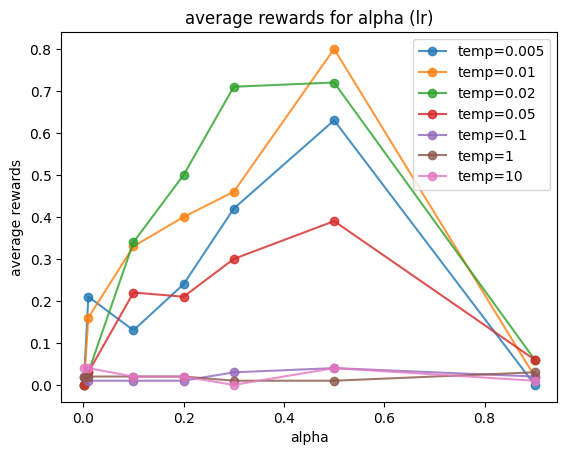

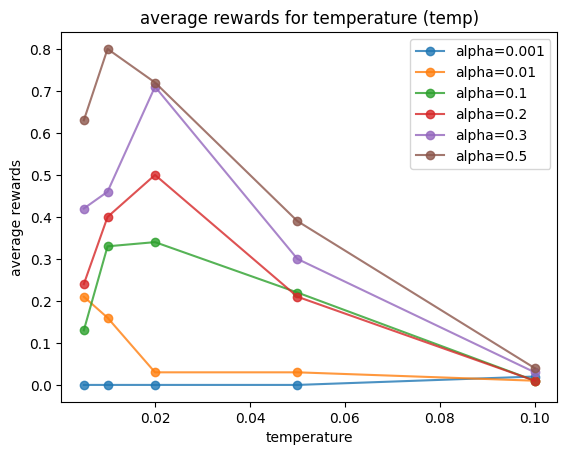

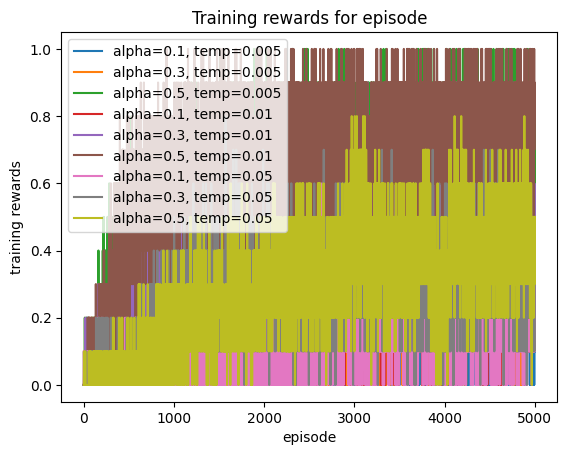

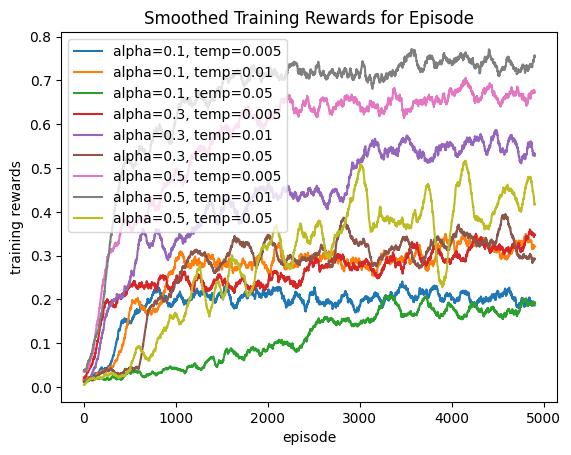

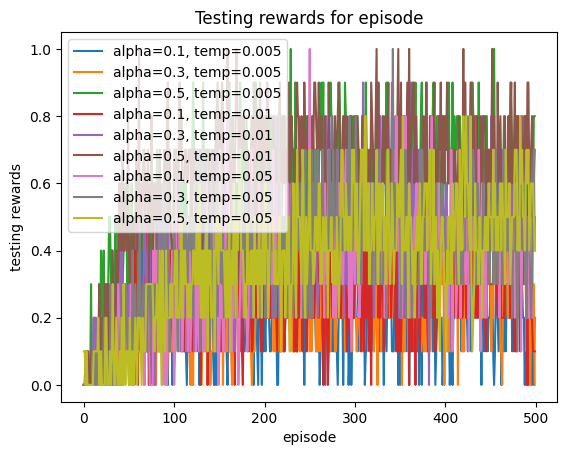

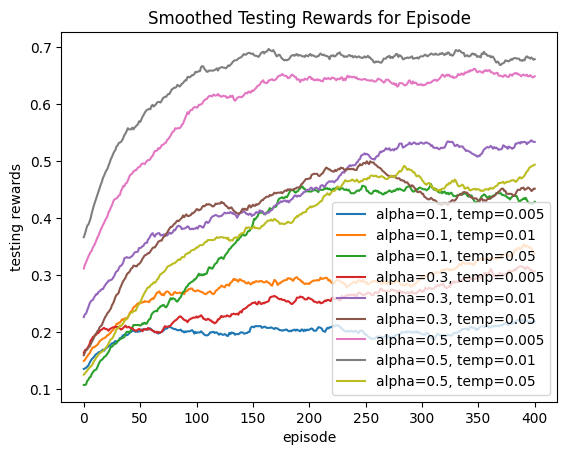

In [17]:
# SARSA PLOTS
plot1(rewards,alphas,temperature)
alpha_2 = [0.001, 0.01,0.1,0.2,0.3,0.5]
temp_2 = [0.005,0.01,0.02,0.05,0.1]
plot2(rewards,alpha_2,temp_2)
alpha_else = [0.1,0.3,0.5]
temp_else = [0.005,0.01,0.05]
plot3(rewards,alpha_else,temp_else)
plot3_smooth(rewards,alpha_else,temp_else)
plot4(rewards,alpha_else,temp_else)
plot4_smooth(rewards,alpha_else,temp_else)

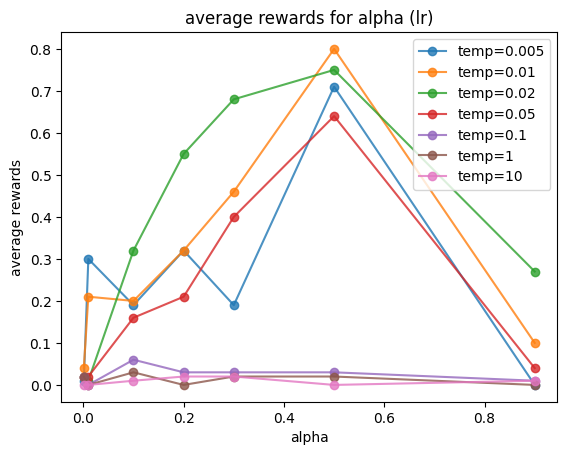

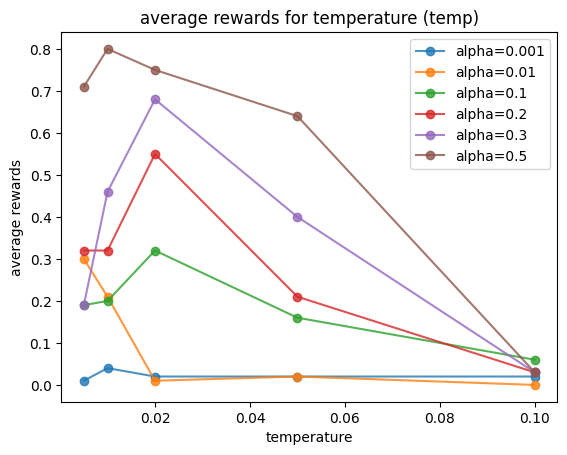

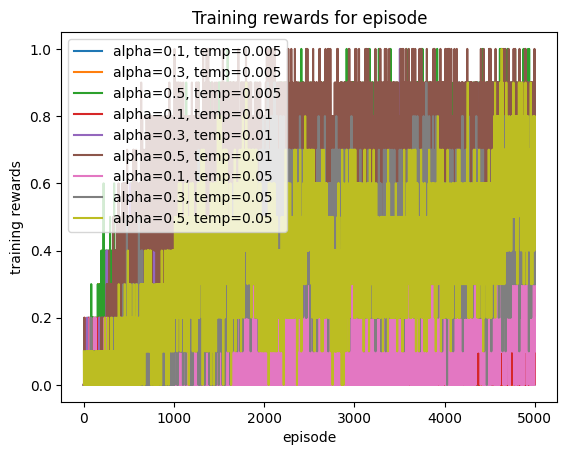

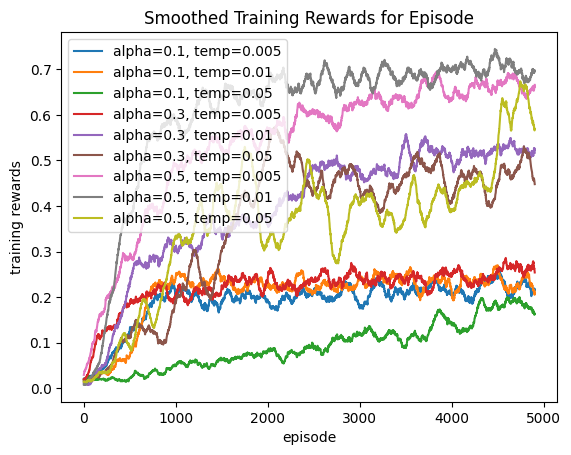

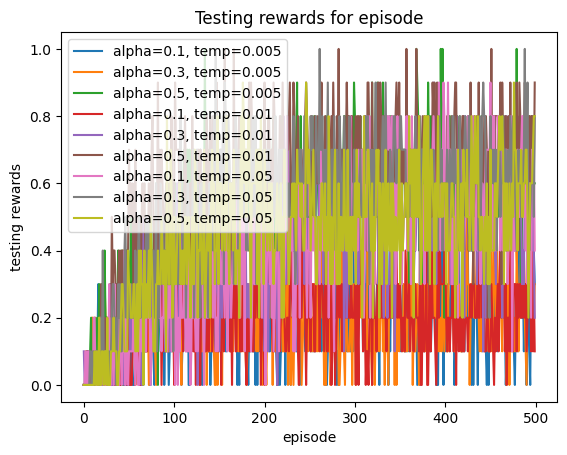

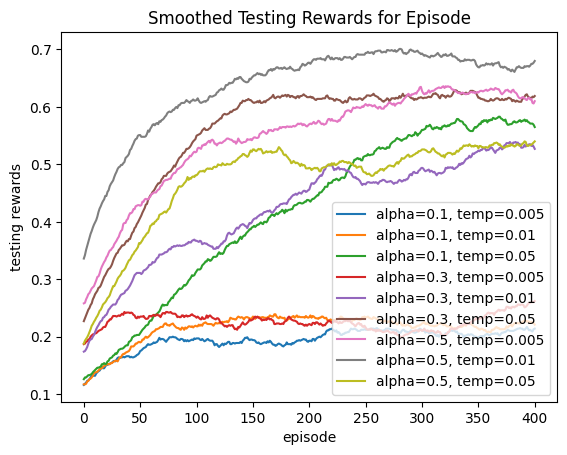

In [18]:
# EXPECTED SARSA PLOTS
plot1(rewards_exp,alphas,temperature)
alpha_2 = [0.001, 0.01,0.1,0.2,0.3,0.5]
temp_2 = [0.005,0.01,0.02,0.05,0.1]
plot2(rewards_exp,alpha_2,temp_2)
alpha_else = [0.1,0.3,0.5]
temp_else = [0.005,0.01,0.05]
plot3(rewards_exp,alpha_else,temp_else)
plot3_smooth(rewards_exp,alpha_else,temp_else)
plot4(rewards_exp,alpha_else,temp_else)
plot4_smooth(rewards_exp,alpha_else,temp_else)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Beginning iteration for alpha 0.1 and temp 0.005
End of iteration for alpha 0.1 and temp 0.005
Time taken: 83.46971702575684 seconds
Beginning iteration for alpha 0.1 and temp 0.01
End of iteration for alpha 0.1 and temp 0.01
Time taken: 61.797757625579834 seconds
Beginning iteration for alpha 0.1 and temp 0.05
End of iteration for alpha 0.1 and temp 0.05
Time taken: 43.165459871292114 seconds
Beginning iteration for alpha 0.3 and temp 0.005
End of iteration for alpha 0.3 and temp 0.005
Time taken: 77.86901354789734 seconds
Beginning iteration for alpha 0.3 and temp 0.01
End of iteration for alpha 0.3 and temp 0.01
Time taken: 71.7002968788147 seconds
Beginning iteration for alpha 0.3 and temp 0.05
End of iteration for alpha 0.3 and temp 0.05
Time taken: 46.60040330886841 seconds
Beginning iteration for alpha 0.5 and temp 0.005
End of iteration for alpha 0.5 and temp 0.005
Time taken: 110.55572390556335 seconds
Beginning iteration for alpha 0.5 and temp 0.01
End of iteration for alpha 

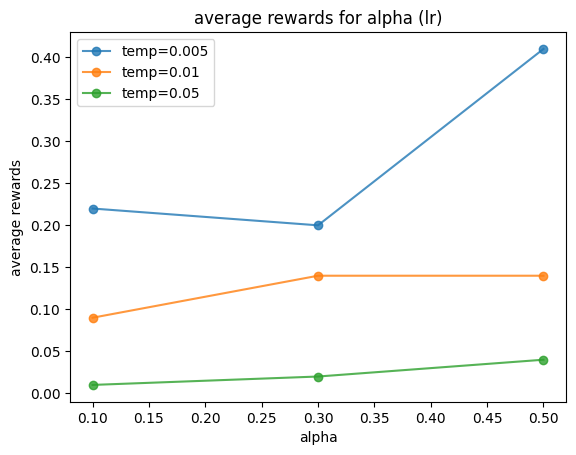

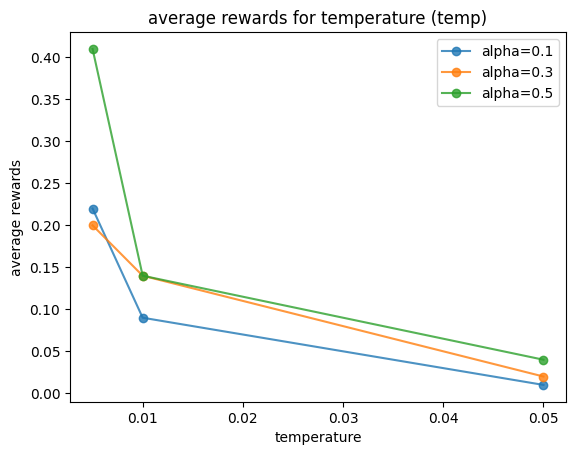

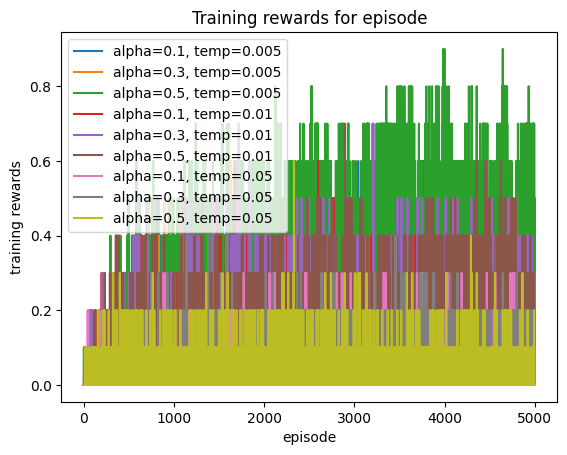

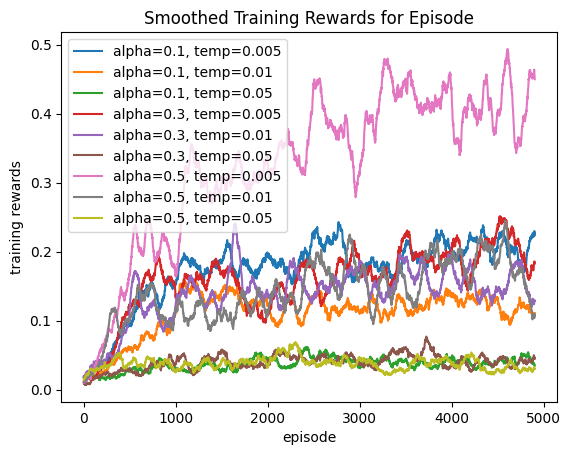

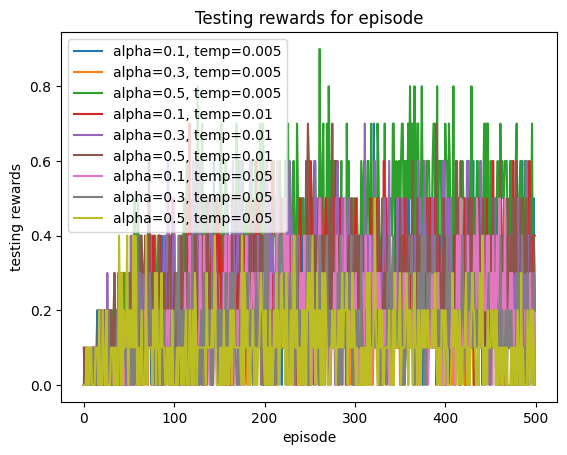

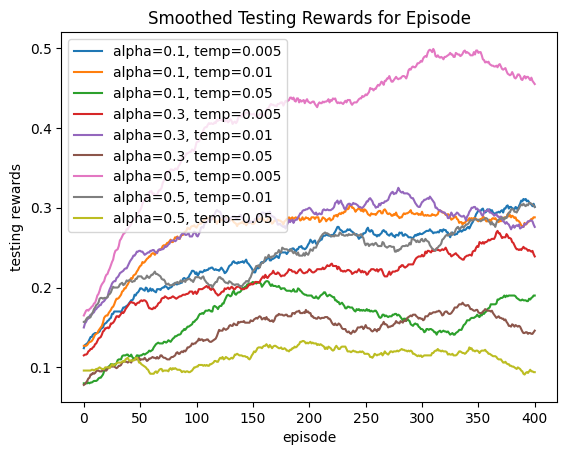

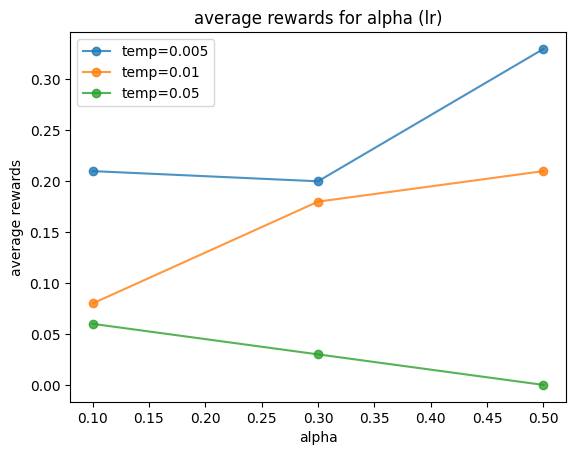

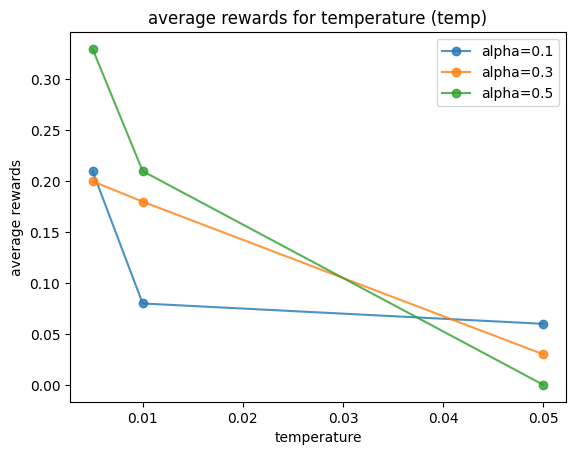

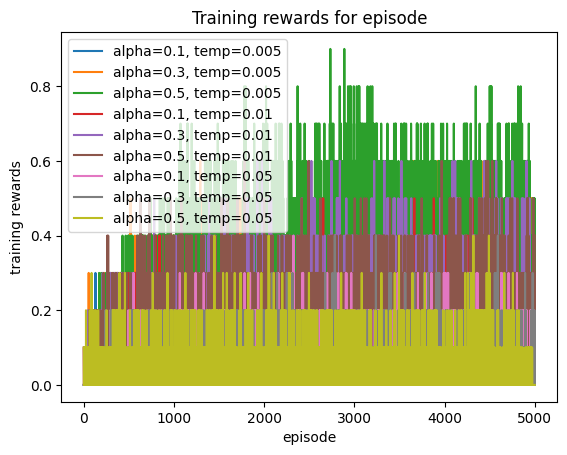

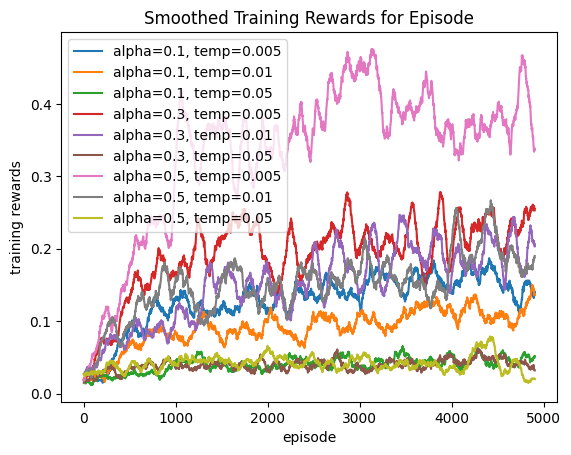

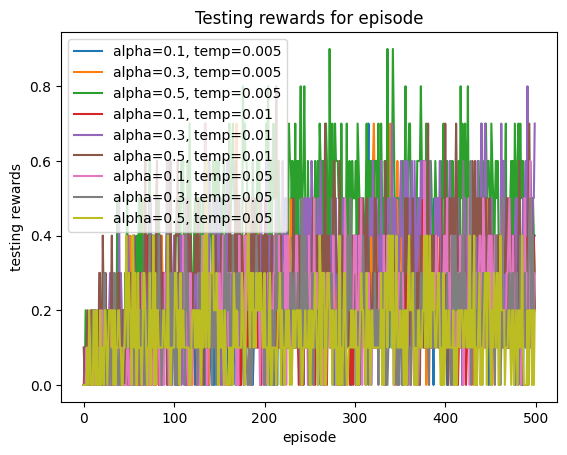

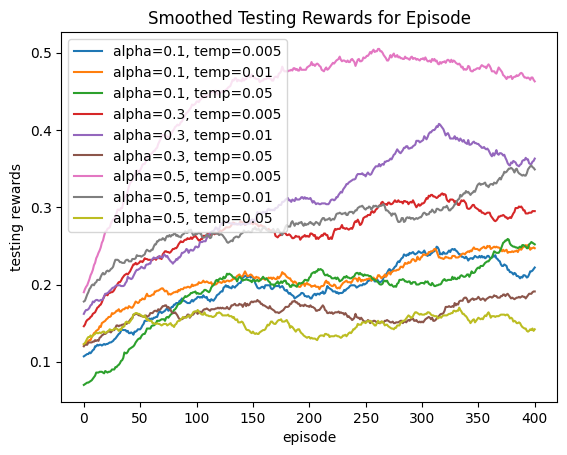

In [ ]:
# impact of changing gamma from 1 to 0.9
subset_alpha = [0.1,0.3,0.5]
subset_temp = [0.005,0.01,0.05]

gamma = 0.9

# Training the SARSA agent on the environment with new gamma
agent_gamma_sarsa = Sarsa(env, 0.1, gamma, 0.005)
rewards_gamma_sarsa = {}
for alpha in subset_alpha:
    for temp in subset_temp:
        print(f"Beginning iteration for alpha {alpha} and temp {temp}")
        beg = time.time()
        training_results_g, testing_results_g = run_experiment(agent_gamma_sarsa, temp, alpha , segments=500, training_episodes=10)
        rewards_gamma_sarsa[(alpha, temp)] = {"training" : training_results_g, "testing" : testing_results_g}
        print(f"End of iteration for alpha {alpha} and temp {temp}")
        final = time.time() - beg
        print(f"Time taken: {final} seconds")

# Training the Expected SARSA agent on the environment with new gamma
agent_gamma_exp = ExpectedSarsa(env, 0.1, gamma, 0.005)
rewards_exp_gamma = {}
for alpha in subset_alpha:
    for temp in subset_temp:
        print(f"Beginning iteration for alpha {alpha} and temp {temp}")
        beg = time.time()
        training_results_eg, testing_results_eg = run_experiment(agent_gamma_exp, temp, alpha , segments=500, training_episodes=10)
        rewards_exp_gamma[(alpha, temp)] = {"training" : training_results_eg, "testing" : testing_results_eg}
        print(f"End of iteration for alpha {alpha} and temp {temp}")
        final = time.time() - beg
        print(f"Time taken: {final} seconds")

# plot :
# FOR SARSA
plot1(rewards_gamma_sarsa,subset_alpha,subset_temp)
plot2(rewards_gamma_sarsa,subset_alpha,subset_temp)
plot3(rewards_gamma_sarsa,subset_alpha,subset_temp)
plot3_smooth(rewards_gamma_sarsa,subset_alpha,subset_temp)
plot4(rewards_gamma_sarsa,subset_alpha,subset_temp)
plot4_smooth(rewards_gamma_sarsa,subset_alpha,subset_temp)

# FOR EXPECTED SARSA
plot1(rewards_exp_gamma,subset_alpha,subset_temp)
plot2(rewards_exp_gamma,subset_alpha,subset_temp)
plot3(rewards_exp_gamma,subset_alpha,subset_temp)
plot3_smooth(rewards_exp_gamma,subset_alpha,subset_temp)
plot4(rewards_exp_gamma,subset_alpha,subset_temp)
plot4_smooth(rewards_exp_gamma,subset_alpha,subset_temp)


Action space: Discrete(4)
State space: Discrete(16)
Beginning iteration for alpha 0.1 and temp 0.005
End of iteration for alpha 0.1 and temp 0.005
Time taken: 28.235048294067383 seconds
Beginning iteration for alpha 0.1 and temp 0.01
End of iteration for alpha 0.1 and temp 0.01
Time taken: 28.70938730239868 seconds
Beginning iteration for alpha 0.1 and temp 0.05
End of iteration for alpha 0.1 and temp 0.05
Time taken: 28.99241065979004 seconds
Beginning iteration for alpha 0.3 and temp 0.005
End of iteration for alpha 0.3 and temp 0.005
Time taken: 28.42807173728943 seconds
Beginning iteration for alpha 0.3 and temp 0.01
End of iteration for alpha 0.3 and temp 0.01
Time taken: 29.40860390663147 seconds
Beginning iteration for alpha 0.3 and temp 0.05
End of iteration for alpha 0.3 and temp 0.05
Time taken: 28.583054304122925 seconds
Beginning iteration for alpha 0.5 and temp 0.005
End of iteration for alpha 0.5 and temp 0.005
Time taken: 28.082055807113647 seconds
Beginning iteration fo

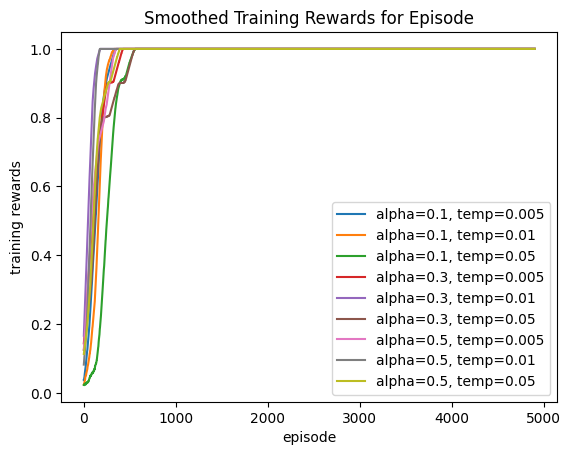

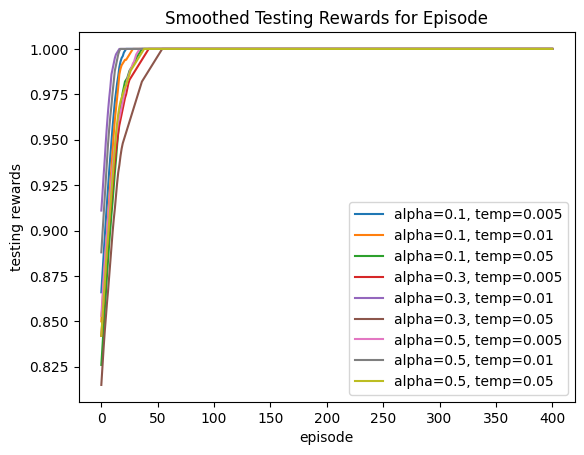

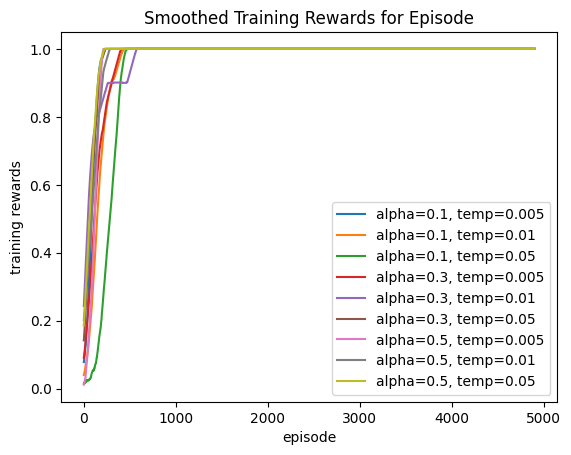

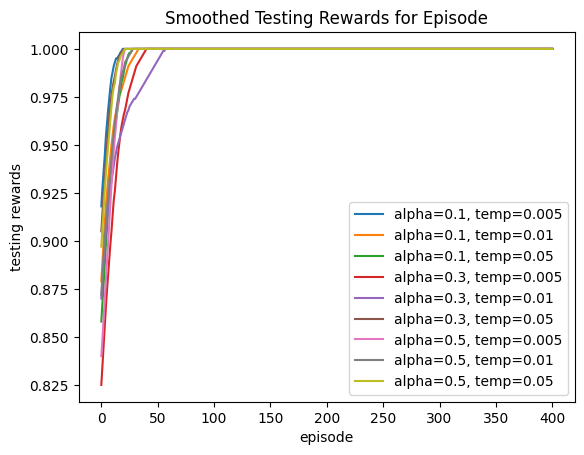

In [48]:
# small experiment on simplyfing the environment with not slippery
env_name = 'FrozenLake-v1'
env = gym.make(env_name,is_slippery=False)
env = StepAPICompatibility(env, new_step_api=True)
print("Action space:", env.action_space)
print("State space:", env.observation_space)
gamma = 1
# Hyperparameters which will be used for training and testing the SARSA and Expected SARSA agents
alphas = [0.1,0.3,0.5]
temperature = [0.005,0.01,0.05]

agent_s = Sarsa(env, 0.1, gamma, 0.005)
rewards_s = {}
for alpha in alphas:
    for temp in temperature:
        print(f"Beginning iteration for alpha {alpha} and temp {temp}")
        beg = time.time()
        training_results_, testing_results_ = run_experiment(agent_s, temp, alpha , segments=500, training_episodes=10)
        rewards_s[(alpha, temp)] = {"training" : training_results_, "testing" : testing_results_}
        print(f"End of iteration for alpha {alpha} and temp {temp}")
        final = time.time() - beg
        print(f"Time taken: {final} seconds")

# Training the Expected SARSA agent on the environment
agent_s = ExpectedSarsa(env, 0.1, gamma, 0.005)
rewards_exp_s = {}
for alpha in alphas:
    for temp in temperature:
        print(f"Beginning iteration for alpha {alpha} and temp {temp}")
        training_results_, testing_results_ = run_experiment(agent_s, temp, alpha , segments=500, training_episodes=10)
        rewards_exp_s[(alpha, temp)] = {"training" : training_results_, "testing" : testing_results_}
        print(f"End of iteration for alpha {alpha} and temp {temp}")

alphas_sub = [0.1,0.3,0.5]
temperature_sub = [0.005,0.01,0.05]
# plot results :
plot3_smooth(rewards_s,alphas_sub,temperature_sub)
plot4_smooth(rewards_s,alphas_sub,temperature_sub)


plot3_smooth(rewards_exp_s,alphas_sub,temperature_sub)
plot4_smooth(rewards_exp_s,alphas_sub,temperature_sub)


